# 04.Modelado predictivo con ML

### Importacion de la data

In [78]:
import pandas as pd
import numpy as np
df_news=pd.read_csv("C:/Repos/Projecto_TRM/Datos/noticias_bitcoin_sentimientos.csv")
df_btc=pd.read_csv("C:/Repos/Projecto_TRM/Datos/BTC_USD_Media_Movil.csv")
df_btc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1097 entries, 0 to 1096
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1096 non-null   object 
 1   Close      1096 non-null   float64
 2   High       1096 non-null   float64
 3   Low        1096 non-null   float64
 4   Open       1096 non-null   float64
 5   Volume     1096 non-null   float64
 6   Close_7d   1090 non-null   float64
 7   Volume_7d  1090 non-null   float64
dtypes: float64(7), object(1)
memory usage: 68.7+ KB


In [2]:
df_news.head()

,fecha,titulo,descripcion,contenido,url,fuente,score
0,2025-04-07,Bitcoin price falls amid tariff market rout,"Bitcoin, the world's largest cryptocurrency by...","The price of bitcoin (BTC-USD), the world's la...",https://ca.finance.yahoo.com/news/bitcoin-pric...,Yahoo Canada Finance,-0.536233
1,2025-04-07,US crypto stocks plunge as bitcoin hits new 20...,U.S.-listed shares of crypto companies tumbled...,(Reuters) - U.S.-listed shares of crypto compa...,https://finance.yahoo.com/news/us-crypto-stock...,Yahoo Finance,-0.637867
2,2025-04-05,SpaceX tourists return to Earth after historic...,Bitcoin investor Chun Wang took three people o...,Four space tourists have safely arrived back o...,https://news.sky.com/story/spacex-tourists-ret...,Sky News,0.630636
3,2025-04-04,BlackRock buys $66M in Bitcoin amid market crash,BlackRock acquired $66 million in Bitcoin on t...,The sell-off in the stock market didn’t cool d...,https://finance.yahoo.com/news/blackrock-buys-...,Yahoo Finance,-0.137903
4,2025-04-04,Markets tumble as Trump launches ‘Unstoppable’...,Markets fell after Trump announced new tariffs...,"On April 3, markets worldwide dropped sharply ...",https://finance.yahoo.com/news/markets-tumble-...,Yahoo Finance,-0.489370


## Preprosesamiento de la data

In [3]:
df_news['fecha'] = pd.to_datetime(df_news['fecha'], format='%Y-%m-%d')

df_news_avg_score = df_news.groupby('fecha')['score'].mean().reset_index()

In [4]:
import plotly.express as px

fig = px.line(df_news_avg_score, x='fecha', y='score', title='Promedio del Score a lo Largo del Tiempo', markers=True)
fig.update_layout(xaxis_title='Fecha', yaxis_title='Avg Score', template='plotly_white')
fig.show()


## Implementacion del modelo

In [83]:
btc_index = df_btc.set_index(pd.to_datetime(df_btc['Date']))['Close'].dropna()
btc_index.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 1096 entries, 2022-04-06 to 2025-04-05
Series name: Close
Non-Null Count  Dtype  
--------------  -----  
1096 non-null   float64
dtypes: float64(1)
memory usage: 17.1 KB


Necesitamos analizar si sus propiedades estadisticas no cambian a lo largo del tiempo. Para ello es necesario aplicar Dickey-Fuller para llegar a una conclusion y actuar a partir de ahi.

### Analisis de Estacionariedad

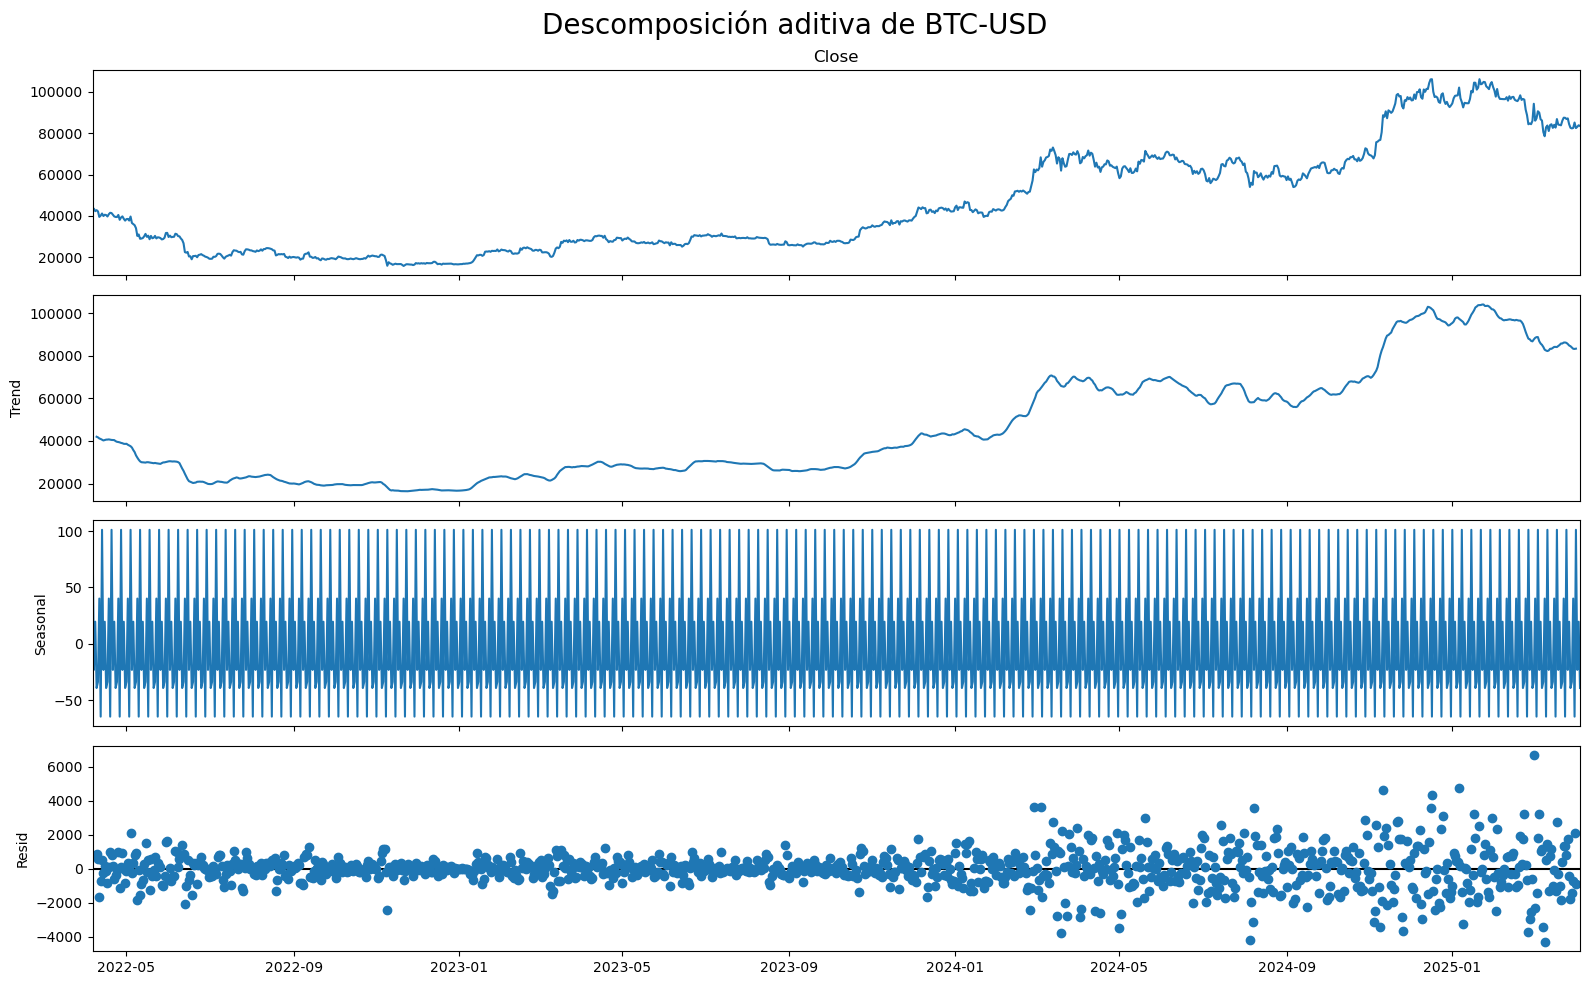

In [86]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Descomposición
result = seasonal_decompose(btc_index, model='additive', period=7)  # puedes ajustar el periodo si conoces una estacionalidad clara
fig = result.plot()
fig.set_size_inches(16, 10)
plt.suptitle('Descomposición aditiva de BTC-USD', fontsize=20)
plt.tight_layout()
plt.show()

### Prueba Dickey Fuller

#### Definimos la funcion para implementar la prueba

In [88]:
from statsmodels.tsa.stattools import adfuller

def prueba_adf(serie, nombre_serie='Serie'):
    """
    Aplica la prueba ADF a una serie temporal y muestra el resultado con interpretación.

    Parámetros:
    - serie: Serie temporal (pandas Series)
    - nombre_serie: Nombre descriptivo de la serie para el encabezado del resultado
    """
    resultado_adf = adfuller(serie.dropna())

    print(f'\n--- Prueba ADF (Augmented Dickey-Fuller) para {nombre_serie} ---')
    print(f'Estadístico ADF: {resultado_adf[0]}')
    print(f'Valor p: {resultado_adf[1]}')
    print('Valores críticos:')
    for key, value in resultado_adf[4].items():
        print(f'   {key}: {value}')

    if resultado_adf[1] <= 0.05:
        print(f"\n✅ {nombre_serie} es estacionaria (rechazamos H0).")
    else:
        print(f"\n❌ {nombre_serie} NO es estacionaria (no se rechaza H0).")


#### Con la serie Original

In [187]:
prueba_adf(df_btc['Close'], 'Precio de cierre del Bitcoin Original')



--- Prueba ADF (Augmented Dickey-Fuller) para Precio de cierre del Bitcoin Original ---
Estadístico ADF: -0.41277959626419064
Valor p: 0.9079430766815466
Valores críticos:
   1%: -3.4364081161854747
   5%: -2.8642149051061954
   10%: -2.5681942108302214

❌ Precio de cierre del Bitcoin Original NO es estacionaria (no se rechaza H0).


####  Con la serie diferenciada

In [188]:
valor_inicial = df_btc['Close'].iloc[0]
serie_diff = df_btc['Close'].diff().dropna()
prueba_adf(serie_diff, 'Precio de cierre del Bitcoin Diferenciado')



--- Prueba ADF (Augmented Dickey-Fuller) para Precio de cierre del Bitcoin Diferenciado ---
Estadístico ADF: -7.9996339957446745
Valor p: 2.352876572073833e-12
Valores críticos:
   1%: -3.4364081161854747
   5%: -2.8642149051061954
   10%: -2.5681942108302214

✅ Precio de cierre del Bitcoin Diferenciado es estacionaria (rechazamos H0).


In [189]:
serie_diff_2 = serie_diff.diff().dropna()
prueba_adf(serie_diff_2, 'Precio de cierre del Bitcoin Diferenciado 2 veces')


--- Prueba ADF (Augmented Dickey-Fuller) para Precio de cierre del Bitcoin Diferenciado 2 veces ---
Estadístico ADF: -11.730080904086758
Valor p: 1.3482235824499878e-21
Valores críticos:
   1%: -3.436470487817901
   5%: -2.8642424166404
   10%: -2.5682088634756735

✅ Precio de cierre del Bitcoin Diferenciado 2 veces es estacionaria (rechazamos H0).


In [250]:
serie_diff_3 = serie_diff_2.diff().dropna()
prueba_adf(serie_diff_3, 'Precio de cierre del Bitcoin Diferenciado 3 veces')


--- Prueba ADF (Augmented Dickey-Fuller) para Precio de cierre del Bitcoin Diferenciado 3 veces ---
Estadístico ADF: -15.773715164654096
Valor p: 1.152854506377434e-28
Valores críticos:
   1%: -3.4364647646486093
   5%: -2.864239892228526
   10%: -2.5682075189699822

✅ Precio de cierre del Bitcoin Diferenciado 3 veces es estacionaria (rechazamos H0).


Vemos que paso la prueba y no tiene fuertes tendencias, ni varianza cambiante por lo que lo revisamos a continuacion:

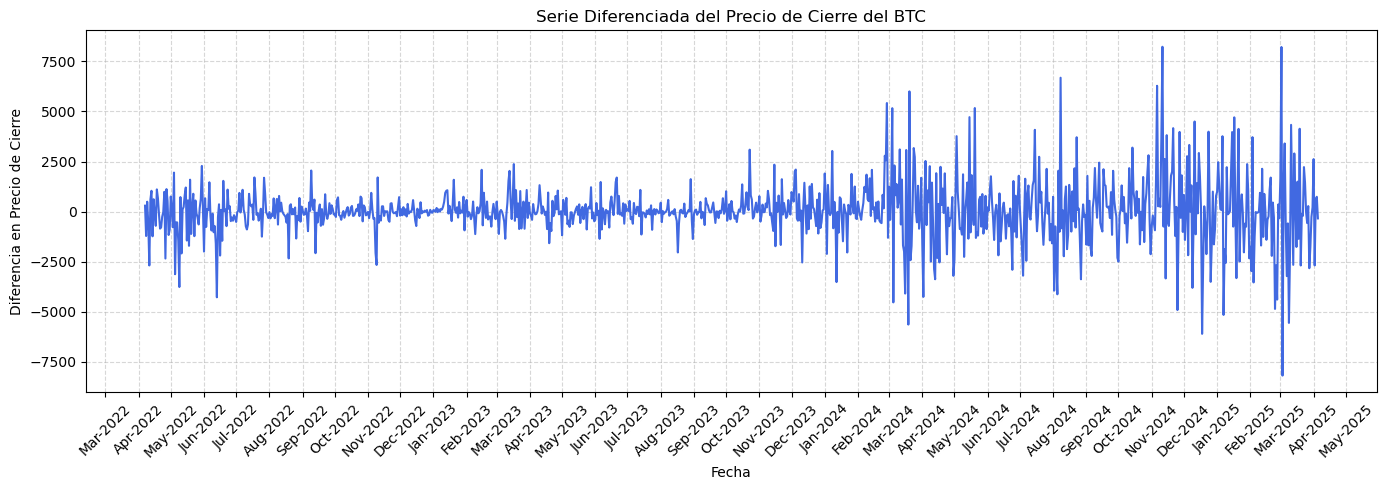

In [253]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Asegúrate de que las fechas sean tipo datetime
df_btc['Date'] = pd.to_datetime(df_btc['Date'])

# Crear la figura
plt.figure(figsize=(14, 5))
plt.plot(df_btc['Date'][2:], serie_diff.values, color='royalblue')

# Títulos y etiquetas
plt.title('Serie Diferenciada del Precio de Cierre del BTC')
plt.xlabel('Fecha')
plt.ylabel('Diferencia en Precio de Cierre')

# Configurar el eje X para mostrar ticks mensuales
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))  

# Mejoras visuales
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


Vemos que los valores de la serie diferenciada giran entorno al eje horizontal y no se observan tendencias marcadas. Vemos que a partir de cierta fecha los valores empiezan a ser mas cambiantes a lo largo del tiempo

In [185]:
# Aplicar logaritmo a la serie original
serie_log = np.log(df_btc['Close']).dropna()
prueba_adf(serie_log, 'Precio de cierre del Bitcoin Logarítmico')


--- Prueba ADF (Augmented Dickey-Fuller) para Precio de cierre del Bitcoin Logarítmico ---
Estadístico ADF: -0.2873761345220865
Valor p: 0.9272733176268361
Valores críticos:
   1%: -3.4363470029475525
   5%: -2.864187948086107
   10%: -2.568179853605536

❌ Precio de cierre del Bitcoin Logarítmico NO es estacionaria (no se rechaza H0).


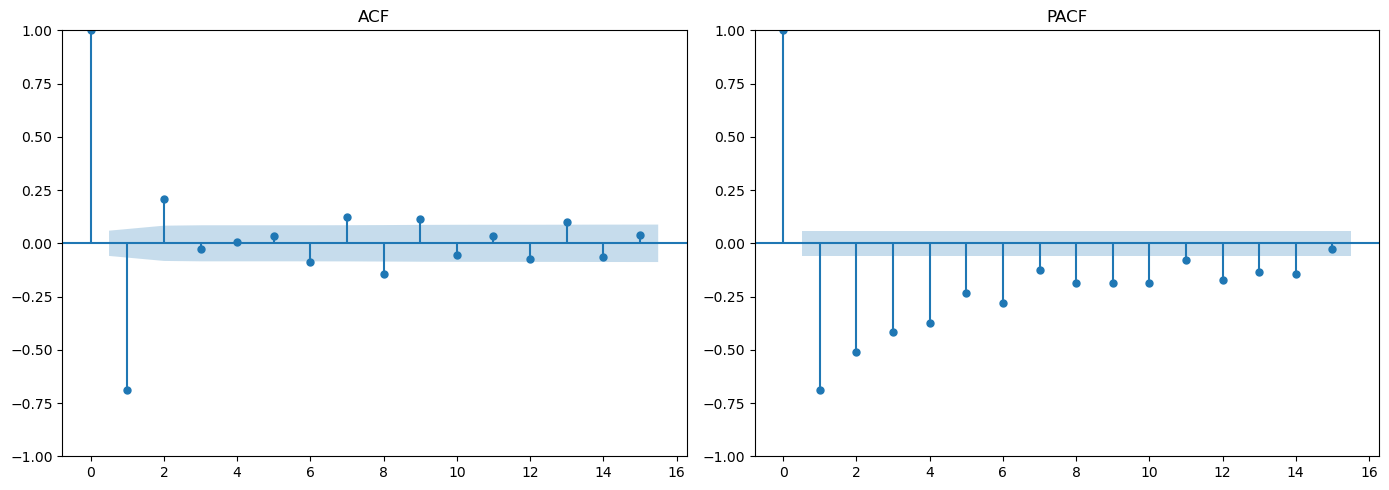

In [254]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plot_acf(serie_diff_3, lags=15, ax=plt.gca())
plt.title("ACF")

plt.subplot(1,2,2)
plot_pacf(serie_diff_3, lags=15, ax=plt.gca(), method='ywm')
plt.title("PACF")

plt.tight_layout()
plt.show()


Al ver el analisis de autocorrelacion solo muestra un pico fuerte en p=1 y q=1 por lo que seleccionaremos estos parametros.

## Arima

In [255]:
from statsmodels.tsa.arima.model import ARIMA

# Entrenar el modelo ARIMA con (p=1, d=0, q=1) como ejemplo, ya que la serie ya está diferenciada
modelo = ARIMA(df_btc['Close'], order=(11, 3, 13))  # d=0 porque ya está diferenciada
modelo_entrenado = modelo.fit()



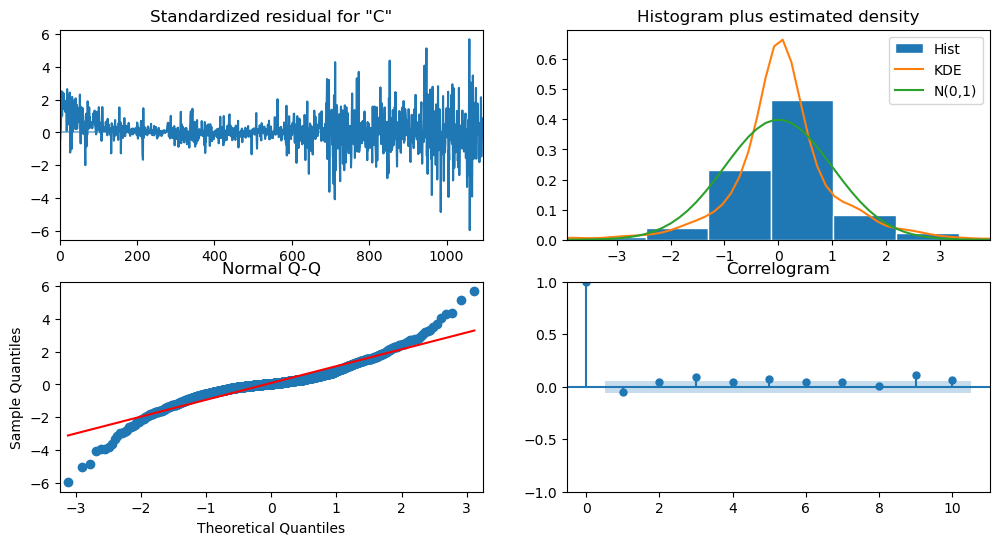

In [256]:
modelo_entrenado.plot_diagnostics(figsize=(12, 6))
plt.show()


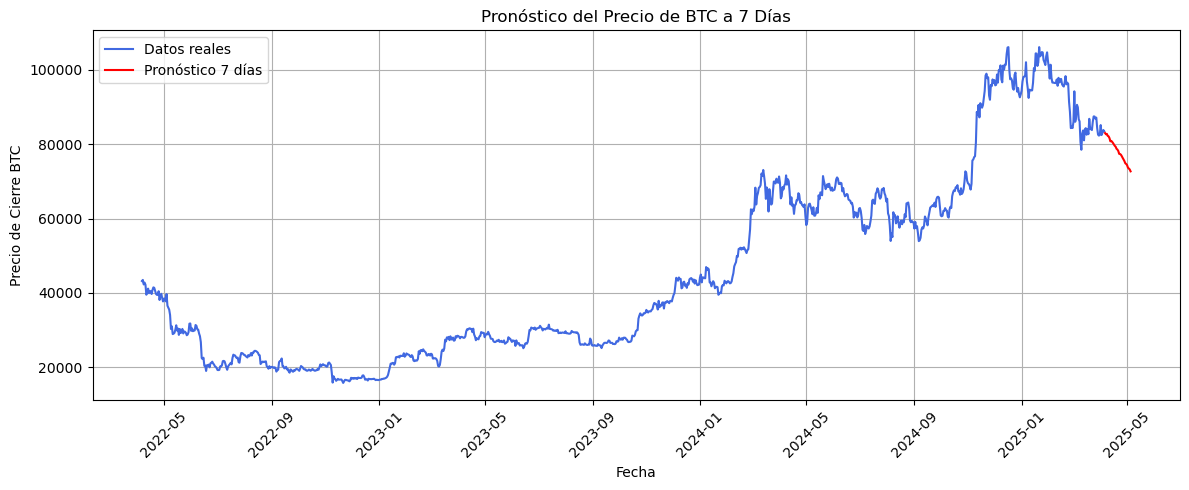

In [260]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Predicción a 7 días
forecast = pd.DataFrame(modelo_entrenado.forecast(steps=30))

# Índice de fechas futuras a partir de la última fecha
fecha_inicio = df_btc['Date'].iloc[-1] + pd.Timedelta(days=1)
forecast_index = pd.date_range(start=fecha_inicio, periods=30, freq='D')
forecast.index = forecast_index

# Visualización
plt.figure(figsize=(12, 5))
plt.plot(df_btc['Date'], df_btc['Close'], label='Datos reales', color='royalblue')
plt.plot(forecast.index, forecast.values, label='Pronóstico 7 días', color='red')
plt.title('Pronóstico del Precio de BTC a 7 Días')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre BTC')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.show()

In [258]:
forecast

,predicted_mean
2025-04-06,83021.647666
2025-04-07,82696.677945
2025-04-08,82803.831841
2025-04-09,82265.090170
2025-04-10,82137.935915
2025-04-11,81663.143557
2025-04-12,80790.398588
2025-04-13,80918.964159
2025-04-14,80674.320167
2025-04-15,80346.530009


In [262]:
#Prueba dickey-fuller para la serie con media movil
prueba_adf(df_btc['Close_7d'], 'Precio de cierre del Bitcoin con media movil')


--- Prueba ADF (Augmented Dickey-Fuller) para Precio de cierre del Bitcoin con media movil ---
Estadístico ADF: -0.6434214751127477
Valor p: 0.8608656736411056
Valores críticos:
   1%: -3.4364934880312177
   5%: -2.8642525616723336
   10%: -2.568214266743025

❌ Precio de cierre del Bitcoin con media movil NO es estacionaria (no se rechaza H0).


In [263]:
serie_media_movil_diff = df_btc['Close_7d'].diff().dropna()
prueba_adf(serie_media_movil_diff, 'Precio de cierre del Bitcoin con media movil Diferenciado')


--- Prueba ADF (Augmented Dickey-Fuller) para Precio de cierre del Bitcoin con media movil Diferenciado ---
Estadístico ADF: -4.923220061742093
Valor p: 3.1420974563487515e-05
Valores críticos:
   1%: -3.4364934880312177
   5%: -2.8642525616723336
   10%: -2.568214266743025

✅ Precio de cierre del Bitcoin con media movil Diferenciado es estacionaria (rechazamos H0).


Text(0.5, 1.0, 'Serie con Media Móvil del Precio de Cierre del BTC')

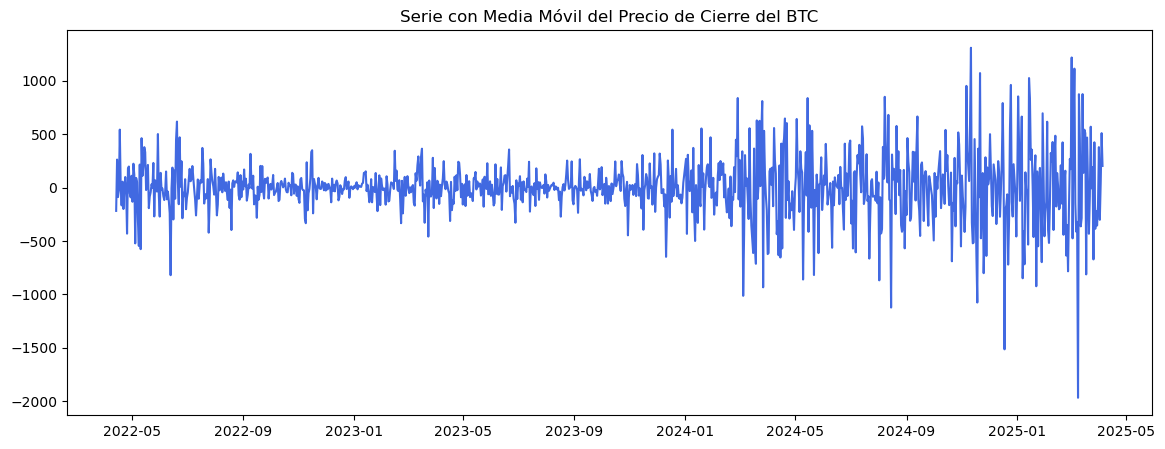

In [275]:
# Graficar la  serie con media móvil
plt.figure(figsize=(14, 5))
plt.plot(df_btc['Date'][8:], serie_media_movil_diff.diff(), color='royalblue')
plt.title('Serie con Media Móvil del Precio de Cierre del BTC')

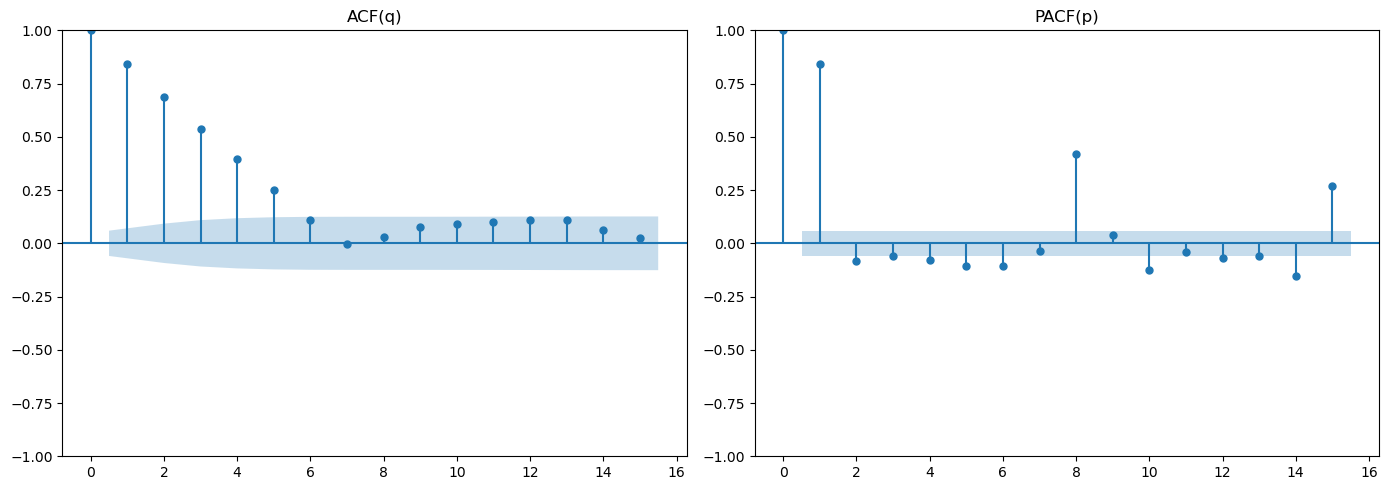

In [277]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plot_acf(serie_media_movil_diff, lags=15, ax=plt.gca())
plt.title("ACF(q)")

plt.subplot(1,2,2)
plot_pacf(serie_media_movil_diff, lags=15, ax=plt.gca(), method='ywm')
plt.title("PACF(p)")

plt.tight_layout()
plt.show()


In [ ]:
from statsmodels.tsa.arima.model import ARIMA
# dividir los datos
train_size = int(len(df_btc) * 0.8)
train, test = df_btc['Close_7d'][:train_size], df_btc['Close_7d'][train_size:]
# Entrenar el modelo ARIMA con (p=4, d=0, q=2) como ejemplo, ya que la serie ya está diferenciada
modelo_med = ARIMA(train, order=(4, 1, 2))  # d=1 porque ya está diferenciada
modelo_med_entrenado = modelo.fit()

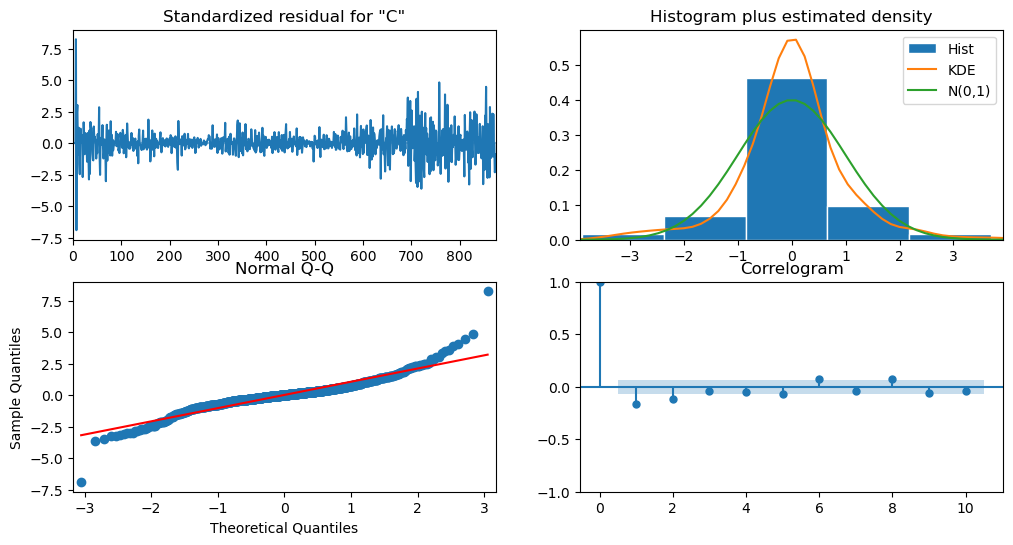

In [298]:
modelo_med_entrenado.plot_diagnostics(figsize=(12, 6))
plt.show()


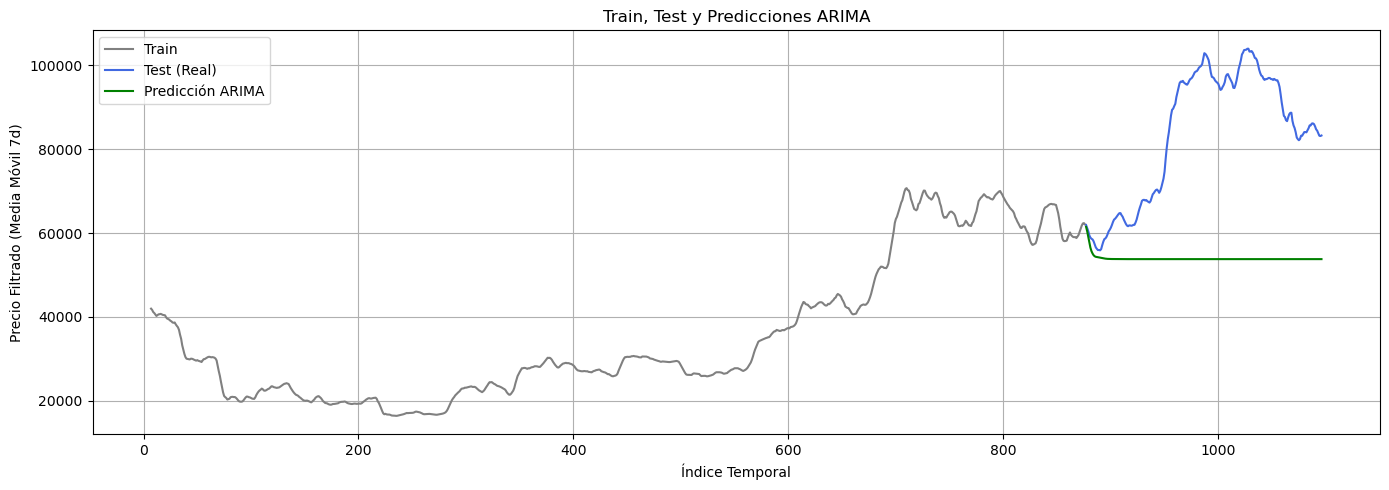

In [299]:
# 3. Hacer predicciones sobre el conjunto de prueba
forecast = modelo_med_entrenado.forecast(steps=len(test))

# 4. Crear el gráfico
plt.figure(figsize=(14, 5))
plt.plot(train.index, train, label='Train', color='gray')
plt.plot(test.index, test, label='Test (Real)', color='royalblue')
plt.plot(test.index, forecast, label='Predicción ARIMA', color='green')
plt.title('Train, Test y Predicciones ARIMA')
plt.xlabel('Índice Temporal')
plt.ylabel('Precio Filtrado (Media Móvil 7d)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Sarima

1. P	Estacional	Autoregresivo estacional (AR estacional)
2. D	Estacional	Diferencias estacionales
3. Q	Estacional	Promedios móviles estacionales (MA estacional)
4. s	Estacional	Periodo estacional (por ejemplo, 7 para datos diarios con patrón semanal)

In [351]:
serie_dif_estacional = df_btc['Close_7d'].diff(7)  # s=7 si semanal

In [352]:
from statsmodels.tsa.stattools import adfuller
prueba_adf(serie_dif_estacional.dropna())



--- Prueba ADF (Augmented Dickey-Fuller) para Serie ---
Estadístico ADF: -5.300973570147041
Valor p: 5.450283886269347e-06
Valores críticos:
   1%: -3.4365341571171166
   5%: -2.8642704999764907
   10%: -2.568223820754717

✅ Serie es estacionaria (rechazamos H0).


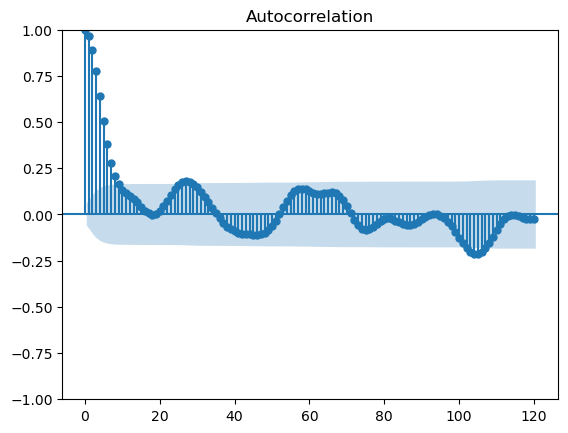

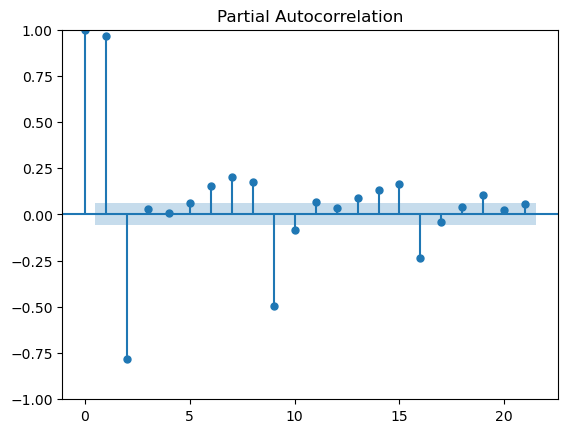

In [353]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(serie_dif_estacional.dropna(), lags=120)
plot_pacf(serie_dif_estacional.dropna(), lags=21)
plt.show()


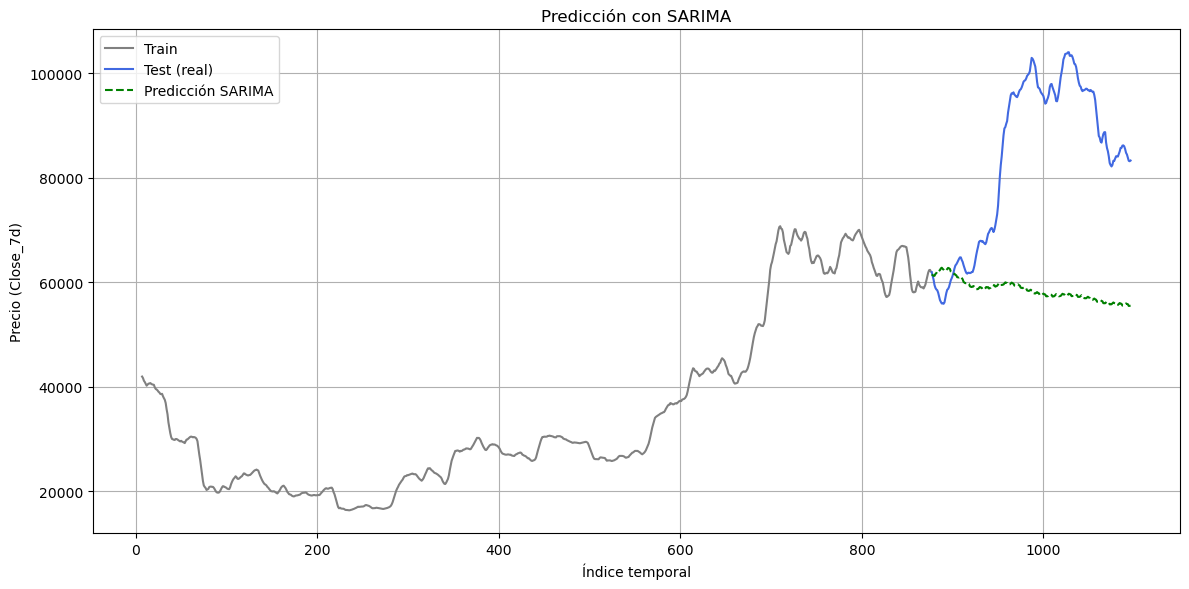

In [354]:
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Entrenar modelo SARIMA
modelo_sarima = SARIMAX(train, order=(4, 1, 2), seasonal_order=(2, 1, 0, 7))
modelo_sarima_fit = modelo_sarima.fit(disp=False)

# Pronóstico sobre el conjunto de test
forecast = modelo_sarima_fit.forecast(steps=len(test))

# Graficar
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train', color='gray')
plt.plot(test.index, test, label='Test (real)', color='royalblue')
plt.plot(test.index, forecast, label='Predicción SARIMA', color='green', linestyle='--')
plt.title('Predicción con SARIMA')
plt.xlabel('Índice temporal')
plt.ylabel('Precio (Close_7d)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [357]:

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

MAE: 26021.54
RMSE: 30352.31


Dado que no se encuentra una tendencia previa se explorara otro modelo, devido a que nuestros datos son muy volatiles

## XGBoost

In [359]:
pip install xgboost

  Using cached xgboost-3.0.0-py3-none-win_amd64.whl.metadata (2.1 kB)
Using cached xgboost-3.0.0-py3-none-win_amd64.whl (150.0 MB)
Note: you may need to restart the kernel to use updated packages.


In [469]:
df_model=df_btc[['Date','Close']]
df_model = pd.merge(df_model, df_news_avg_score, how='left', left_on='Date', right_on='fecha')
df_model.fillna(0, inplace=True)
df_model.drop(columns=['fecha'], inplace=True)
df_model['Date'] = pd.to_datetime(df_model['Date'])


In [470]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1097 entries, 0 to 1096
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1097 non-null   datetime64[ns]
 1   Close   1097 non-null   float64       
 2   score   1097 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 25.8 KB


In [471]:
df_model

,Date,Close,score
0,1970-01-01,0.000000,0.000000
1,2022-04-06,43206.738281,0.000000
2,2022-04-07,43503.847656,0.000000
3,2022-04-08,42287.664062,0.000000
4,2022-04-09,42782.136719,0.000000
...,...,...,...
1092,2025-04-01,85169.171875,-0.084074
1093,2025-04-02,82485.710938,-0.226506
1094,2025-04-03,83102.828125,0.000000
1095,2025-04-04,83843.804688,-0.313637


In [475]:
model.feature_names_in_

array(['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7'],
      dtype='<U5')

MAE: 18203.55
RMSE: 22217.48


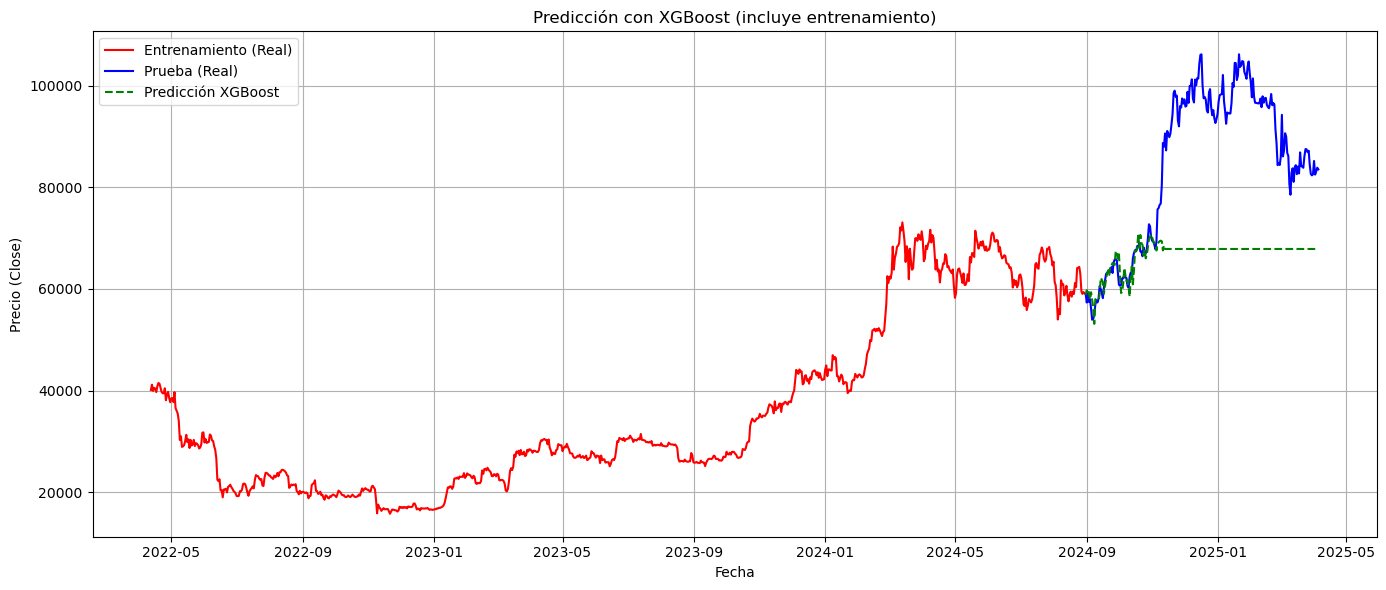

In [488]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 1. Crear variables rezagadas (lags)
def crear_lags(data, target_col, n_lags):
    df = data.copy()
    for lag in range(1, n_lags + 1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    return df.dropna()

# --- Configuración ---
n_lags = 7

# 2. Crear dataset con lags
df_lags = crear_lags(df_model, 'Close', n_lags)

# 3. Separar en train/test
train_size = int(len(df_lags) * 0.80)
train = df_lags.iloc[:train_size]
test = df_lags.iloc[train_size:]

X_train = train.drop(columns=['Close', 'Date','score'])
y_train = train['Close']
X_test = test.drop(columns=['Close', 'Date','score'])
y_test = test['Close']

# 4. Entrenar modelo XGBoost
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.1,
    min_child_weight=5,
    reg_alpha=0.1,
    reg_lambda=1,
    random_state=42
)
model.fit(X_train, y_train)

# 5. Predicciones y métricas
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

# 6. Visualización completa
plt.figure(figsize=(14, 6))

# Entrenamiento en rojo
plt.plot(df_model['Date'][y_train.index], y_train.values, label='Entrenamiento (Real)', color='red')

# Test real en azul
plt.plot(df_model['Date'][y_test.index], y_test.values, label='Prueba (Real)', color='blue')

# Predicción en verde
plt.plot(df_model['Date'][y_test.index], y_pred, label='Predicción XGBoost', color='green', linestyle='--')

plt.title('Predicción con XGBoost (incluye entrenamiento)')
plt.xlabel('Fecha')
plt.ylabel('Precio (Close)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
1097

109.7

In [479]:
model_sent.feature_names_in_

array(['score', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6',
       'lag_7'], dtype='<U5')

MAE: 18099.52
RMSE: 22084.68


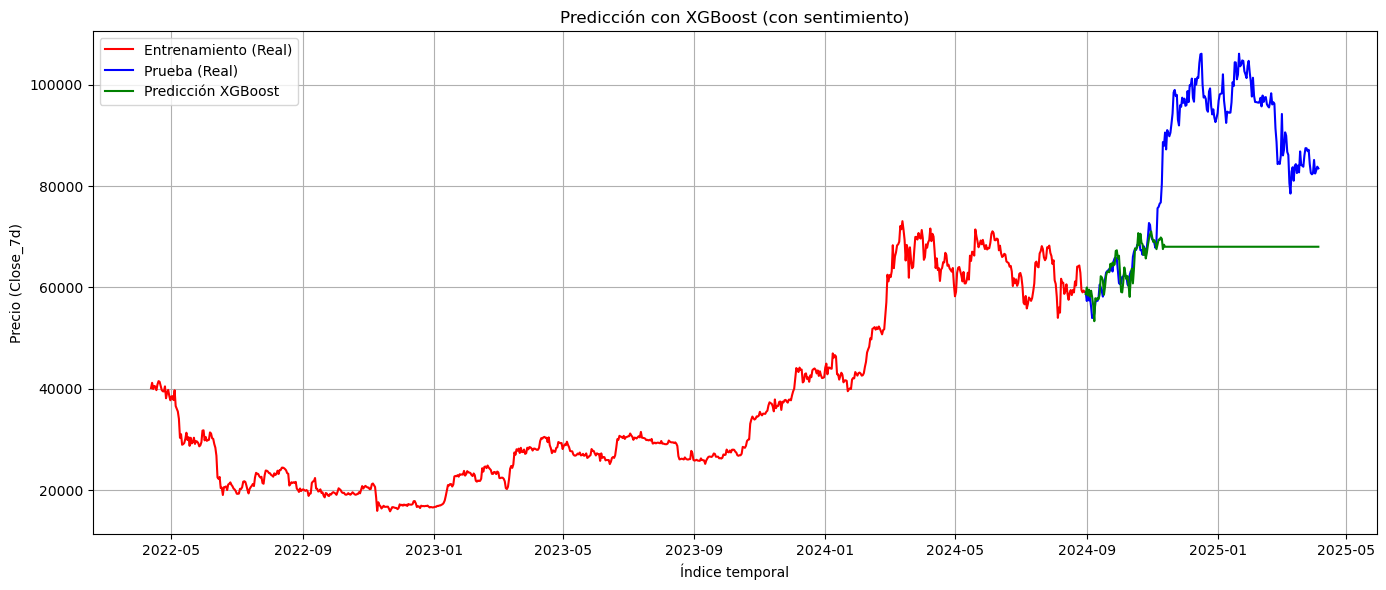

In [487]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 1. Crear variables rezagadas (lags)
def crear_lags(data, target_col, n_lags):
    df = data.copy()
    for lag in range(1, n_lags + 1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    return df.dropna()

# Supón que tienes un DataFrame llamado df con una columna 'Close_7d'
# Reemplaza esto si tu DataFrame se llama distinto
n_lags = 7
df_lags = crear_lags(df_model, 'Close', n_lags)
# 2. Separar en conjunto de entrenamiento y prueba (80/20)
train_size = int(len(df_lags) * 0.80)
train = df_lags.iloc[:train_size]
test = df_lags.iloc[train_size:]

X_train = train.drop(columns=['Close', 'Date'])
y_train = train['Close']
X_test = test.drop(columns=['Close', 'Date'])
y_test = test['Close']

# 3. Entrenar el modelo XGBoost
model_sent = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.1,
    min_child_weight=5,
    reg_alpha=0.1,
    reg_lambda=1,
    random_state=42
)

model_sent.fit(X_train, y_train)

# 4. Predicciones
y_pred = model_sent.predict(X_test)

# 5. Evaluación
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

plt.figure(figsize=(14, 6))

# Graficar entrenamiento en rojo
plt.plot(df_btc['Date'][y_train.index], y_train.values, label='Entrenamiento (Real)', color='red')

# Graficar prueba real en azul
plt.plot(df_btc['Date'][y_test.index], y_test.values, label='Prueba (Real)', color='blue')

# Graficar predicción en verde punteado
plt.plot(df_btc['Date'][y_test.index], y_pred, label='Predicción XGBoost', color='green')

# Estética
plt.title('Predicción con XGBoost (con sentimiento)')
plt.xlabel('Índice temporal')
plt.ylabel('Precio (Close_7d)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




In [484]:
# --- 6. Predicción futura de 7 días ---
# Copiamos la última fila con todos los lags y sentimiento
ultimas_filas = df_lags.iloc[-n_lags:].copy()
predicciones_futuras = []

# Empezamos con los últimos valores reales
lags_actuales = list(ultimas_filas['Close'].values[-n_lags:])
sent_actual = df_model['score'].iloc[-1]  # Último sentimiento conocido

for i in range(7):  # Predecir 7 días
    # Crear un input para el modelo
    entrada = {f'lag_{j+1}': lags_actuales[-(j+1)] for j in range(n_lags)}
    entrada['score'] = sent_actual
    
    X_futuro = pd.DataFrame([entrada])
    prediccion = model_sent.predict(X_futuro)[0]
    predicciones_futuras.append(prediccion)
    
    # Actualizamos lags con la nueva predicción
    lags_actuales.append(prediccion)

# Crear rango de fechas a futuro
ultima_fecha = df_model['Date'].max()
fechas_futuras = pd.date_range(start=ultima_fecha + pd.Timedelta(days=1), periods=7)

# Mostrar resultados
for fecha, valor in zip(fechas_futuras, predicciones_futuras):
    print(f"{fecha.date()}: {valor:.2f}")

# Graficar junto con los datos reales
plt.figure(figsize=(14, 6))

# Datos reales recientes
plt.plot(df_model['Date'], df_model['Close'], label='Precio real', color='blue')

# Futuro
plt.plot(fechas_futuras, predicciones_futuras, label='Predicción 7 días (XGBoost + sentimiento)', color='green', linestyle='--')

plt.title('Predicción de 7 días a futuro con XGBoost')
plt.xlabel('Fecha')
plt.ylabel('Precio (Close)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


ValueError: feature_names mismatch: ['score', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7'] ['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'score']

In [451]:
(1006/1097)*100

91.70464904284412

In [443]:
df_model['Date'].iloc[int(df_model['Date'].size*0.8)]

Timestamp('2024-08-29 00:00:00')

In [444]:
df_news_avg_score

,fecha,score
0,2025-01-05,0.130265
1,2025-01-06,0.532647
2,2025-01-07,0.103140
3,2025-01-08,0.069138
4,2025-01-09,-0.096629
...,...,...
73,2025-04-01,-0.084074
74,2025-04-02,-0.226506
75,2025-04-04,-0.313637
76,2025-04-05,0.630636


Index([1006], dtype='int64')

KeyError: 'Sentimiento'

Vemos que nuestro modelo presenta una alta variablididad especialmente a finales de 2024 y principios de 2025 por lo que nos vamos a apoyar con las noticias.

MAE por split: [1292.02069344  774.15658897  620.77960356  878.20327027 9797.04393724
 1152.11389463 5306.82037707 2769.86918905]
MAE promedio: 2823.88
RMSE por split: [ 1827.31236071  1281.90888804   866.56942823  1414.1025232
 14572.63700146  1646.89731544 10364.09802707  3677.82119011]
RMSE promedio: 4456.42


## Analisis con Prophet

In [ ]:
pip install prophet

   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
    --------------------------------------- 0.3/13.3 MB 9.6 MB/s eta 0:00:02
   - -------------------------------------- 0.6/13.3 MB 7.7 MB/s eta 0:00:02
   ---- ----------------------------------- 1.4/13.3 MB 10.7 MB/s eta 0:00:02
   ----- ---------------------------------- 1.8/13.3 MB 10.5 MB/s eta 0:00:02
   ------- -------------------------------- 2.4/13.3 MB 11.1 MB/s eta 0:00:01
   -------- ------------------------------- 3.0/13.3 MB 11.2 MB/s eta 0:00:01
   ----------- ---------------------------- 3.7/13.3 MB 11.3 MB/s eta 0:00:01
   ------------- -------------------------- 4.6/13.3 MB 11.3 MB/s eta 0:00:01
   --------------- ------------------------ 5.3/13.3 MB 11.2 MB/s eta 0:00:01
   ----------------- ---------------------- 5.8/13.3 MB 11.3 MB/s eta 0:00:01
   ------------------- -------------------- 6.5/13.3 MB 11.5 MB/s eta 0:00:01
   --------------------- ------------------ 7.1/13.3 MB 11.4 MB/s eta 0:00

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_squared_error

#############################################
# 1) Prepare Data for Prophet
#############################################

# Suppose eth_df has a Date index and a column named 'price'.
# Example schema: eth_df.columns -> ['price'], eth_df.index -> DatetimeIndex

# Reset index to turn the Date into a column named 'ds'
prophet_df = df_btc[['Date','Close']].reset_index().rename(columns={'Date': 'ds', 'Close': 'y'})
# 'ds' must be datetime, 'y' is the numeric value to forecast
prophet_df['ds'] = pd.to_datetime(prophet_df['ds'])

# Train/Test Split
train_size = int(len(prophet_df) * 0.8)
train_prophet = prophet_df[:train_size].copy()
test_prophet  = prophet_df[train_size:].copy()


print("[DEBUG] Prophet univariate data:")
print(prophet_df.head())

[DEBUG] Prophet univariate data:
   index         ds             y
0      0        NaT           NaN
1      1 2022-04-06  43206.738281
2      2 2022-04-07  43503.847656
3      3 2022-04-08  42287.664062
4      4 2022-04-09  42782.136719


In [ ]:
prophet_df.dropna(inplace=True)
prophet_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1096 entries, 1 to 1096
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   index   1096 non-null   int64         
 1   ds      1096 non-null   datetime64[ns]
 2   y       1096 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 34.2 KB


In [ ]:
train_prophet = train_prophet[['ds', 'y']]
test_prophet = test_prophet[['ds', 'y']]


In [ ]:
print(train_prophet.head())
print(test_prophet.head())

          ds             y
0        NaT           NaN
1 2022-04-06  43206.738281
2 2022-04-07  43503.847656
3 2022-04-08  42287.664062
4 2022-04-09  42782.136719
            ds             y
877 2024-08-29  59388.179688
878 2024-08-30  59119.476562
879 2024-08-31  58969.898438
880 2024-09-01  57325.488281
881 2024-09-02  59112.480469


In [ ]:
import prophet
print(prophet.__version__)


1.1.6


In [ ]:
pip install cmdstanpy

In [ ]:
pip install --upgrade prophet


Note: you may need to restart the kernel to use updated packages.


In [ ]:
from prophet import Prophet
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  # <-- faltaba esto

# Inicializar modelo Prophet
m_baseline = Prophet(daily_seasonality=True)
m_baseline.fit(train_prophet)

# Crear un dataframe futuro con la longitud del test
future_baseline = m_baseline.make_future_dataframe(periods=len(test_prophet))
forecast_baseline = m_baseline.predict(future_baseline)

# Evaluar RMSE en el test
merged_baseline = pd.merge(
    test_prophet[['ds', 'y']],
    forecast_baseline[['ds', 'yhat']],
    on='ds', how='left'
)
rmse_baseline = np.sqrt(mean_squared_error(merged_baseline['y'], merged_baseline['yhat']))
print(f"\n[DEBUG] Baseline Prophet RMSE: {rmse_baseline:.4f}")

# Graficar el forecast
fig = m_baseline.plot(forecast_baseline)
plt.title("Prophet Baseline Forecast (No Sentiment)")
plt.show()


AttributeError: 'Prophet' object has no attribute 'stan_backend'